<a href="https://colab.research.google.com/github/ChaikhiBelaid/ChaikhiBelaid.github.io/blob/master/Shoe_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction: 
This work has been created by Belaid CHAIKHI in the context of a the EdgeNet challenge proposed by Tocoders.com. I would like to think every one who help to improve my skills that are essentials to make this project good.


#Prepare the data

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from PIL import Image 

In [3]:
! pip install bing-image-downloader

In [4]:
from bing_image_downloader import downloader

In [5]:
list_classes = ['sneakers', 'boots', 'loafers', 'sandals', 'flip_flops', 'soccer_shoes', 'no_shoe_found']

In [6]:
for classe in list_classes :
  downloader.download(classe, 350, 'Shoe_Dataset')

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[%] Downloading Image #293 from https://n3.sdlcdn.com/imgs/d/a/r/True-Soles-Multi-Color-Loafers-SDL628781719-3-7f6de.jpg
[%] File Downloaded !

[%] Downloading Image #294 from https://cdnd.lystit.com/photos/2013/10/24/gucci-brown-horsebit-suede-loafers-product-6-14463443-205546312.jpeg
[%] File Downloaded !

[%] Downloading Image #295 from https://cdna.lystit.com/photos/matchesfashion/56adc232/grenson-DARK-BROWN-Lloyd-Leather-Loafers.jpeg
[%] File Downloaded !

[%] Downloading Image #296 from https://i.pinimg.com/originals/c7/58/ad/c758ad37ec6197edbdd7d9d24cba42f5.jpg
[%] File Downloaded !

[%] Downloading Image #297 from https://i.pinimg.com/originals/9a/42/28/9a422876f013aed4c45034e857b257c4.jpg
[%] File Downloaded !

[%] Downloading Image #298 from https://i.pinimg.com/originals/bc/62/51/bc625129dac677198ce7f1a988c8b3f7.png
[%] File Downloaded !

[%] Downloading Image #299 from http://cdnb.lystit.com/photo

In [7]:
print('----------------------')
for classe in list_classes : 
  print('number of images in the classe ', classe)
  print(len(os.listdir(os.path.join('Shoe_Dataset/', classe))))
  print('----------------------')

----------------------
number of images in the classe  sneakers
350
----------------------
number of images in the classe  boots
350
----------------------
number of images in the classe  loafers
350
----------------------
number of images in the classe  sandals
350
----------------------
number of images in the classe  flip_flops
350
----------------------
number of images in the classe  soccer_shoes
350
----------------------
number of images in the classe  no_shoe_found
350
----------------------


In [8]:
try:
    os.mkdir('ShoeDataset')
    os.mkdir('ShoeDataset/training')
    os.mkdir('ShoeDataset/testing')
    for classe in list_classes :
      path_train = os.path.join('ShoeDataset/training/', classe)
      path_test = os.path.join('ShoeDataset/testing/', classe)
      os.mkdir(path_train)
      os.mkdir(path_test)
except OSError:
    pass

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE, CLASSE):
    files = []
    target_size = (150, 150)
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]
    k = 0
    for filename in training_set:
        k+=1
        this_file = os.path.join(SOURCE, filename)
        img = Image.open(this_file)
        img = img.resize(target_size, Image.ANTIALIAS)
        file_name = CLASSE+'image_train_'+str(k)+'.jpg'
        img.convert('RGB').save(file_name)
        destination = os.path.join(TRAINING, file_name) 
        copyfile(file_name, destination)
        os.remove(file_name)
    p = 0
    for filename in testing_set:
        p+=1
        this_file = os.path.join(SOURCE, filename)
        img = Image.open(this_file)
        img = img.resize(target_size, Image.ANTIALIAS)
        file_name = CLASSE+'_image_test_'+str(p)+'.jpg'
        img.convert('RGB').save(file_name)
        destination = os.path.join(TESTING, file_name) 
        copyfile(file_name, destination)
        os.remove(file_name)

In [10]:
SPLIT_SIZE = .8
for classe in list_classes : 
  SOURCE = os.path.join('Shoe_Dataset', classe)
  TRAINING = os.path.join('ShoeDataset/training', classe)
  TESTING = os.path.join('ShoeDataset/testing', classe)
  split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE,classe)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 2. 
  warnings.warn(str(msg))


In [11]:

for classe in list_classes :
  print(classe)
  print('for training ')
  print(len(os.listdir(os.path.join('ShoeDataset/training',classe))))
  print('for testing')
  print(len(os.listdir(os.path.join('ShoeDataset/testing',classe))))
  print('-------------')

sneakers
for training 
280
for testing
70
-------------
boots
for training 
280
for testing
70
-------------
loafers
for training 
280
for testing
70
-------------
sandals
for training 
280
for testing
70
-------------
flip_flops
for training 
280
for testing
70
-------------
soccer_shoes
for training 
280
for testing
70
-------------
no_shoe_found
for training 
280
for testing
70
-------------


#Build The model : VGG19


In [12]:
#libraries 
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import SGD

In [13]:
def define_model():
    n_classes = len(list_classes)
    # load model
    model = VGG19(weights='imagenet',
                include_top=False, 
                input_shape=(150, 150, 3)
                )
    # mark loaded layers as not trainable
    for layer in model.layers:
      layer.trainable = False
    # add new classifier layers
    last_layer_output = model.layers[-1].output
    x = Flatten()(last_layer_output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(.2)(x)
    output = Dense(n_classes, activation='softmax')(x)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model, model.summary()

In [14]:
model, model_summary = define_model()
model_summary

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
TRAINING_DIR = "ShoeDataset/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,
                                   rotation_range=2,
                                   horizontal_flip=True,
                                   zoom_range=.1
                                   )
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150)
                                                    )

VALIDATION_DIR = "ShoeDataset/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.,
                                        rotation_range=2,
                                        horizontal_flip=True,
                                        zoom_range=.1
                                        )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(150, 150)
                                                              )

Found 1960 images belonging to 7 classes.
Found 490 images belonging to 7 classes.


#Train the model 

In [16]:
training_steps = (1960//32)
validation_steps = 6
history = model.fit(
                    train_generator, 
                    epochs = 10, 
                    steps_per_epoch = training_steps,
                    validation_data = validation_generator, 
                    validation_steps = validation_steps
                    )

Epoch 1/10
61/61 [==============================] - 359s 6s/step - loss: 1.9874 - accuracy: 0.2172 - val_loss: 1.4977 - val_accuracy: 0.4583
Epoch 2/10
61/61 [==============================] - 337s 6s/step - loss: 1.3901 - accuracy: 0.5090 - val_loss: 1.2915 - val_accuracy: 0.5000
Epoch 3/10
61/61 [==============================] - 335s 5s/step - loss: 1.1813 - accuracy: 0.5905 - val_loss: 1.0789 - val_accuracy: 0.6588
Epoch 4/10
61/61 [==============================] - 336s 6s/step - loss: 0.9763 - accuracy: 0.6707 - val_loss: 1.1006 - val_accuracy: 0.6198
Epoch 5/10
61/61 [==============================] - 333s 5s/step - loss: 0.9838 - accuracy: 0.6552 - val_loss: 1.0199 - val_accuracy: 0.6353
Epoch 6/10
61/61 [==============================] - 336s 6s/step - loss: 0.8405 - accuracy: 0.6949 - val_loss: 0.9850 - val_accuracy: 0.6354
Epoch 7/10
61/61 [==============================] - 332s 5s/step - loss: 0.7960 - accuracy: 0.7197 - val_loss: 0.8520 - val_accuracy: 0.7529
Epoch 8/10
61

In [17]:
model.save('Shoe_Classifier.h5') 

#Visualize the accuracy of the model 

<Figure size 432x288 with 0 Axes>

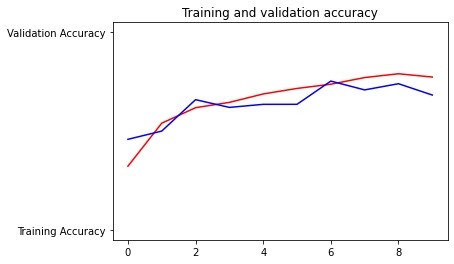

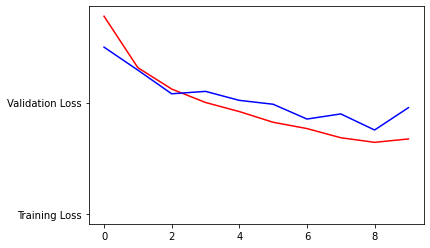

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


#Predict some new images 

In [31]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
# predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print("predictions")
  index = np.argmax(classes[0])
  print(classes[0])
  print(f'the classe of this image is : {list_classes[index]} with a probability of {round(classes[0][index]*100, 2)}%')
  print('-------------------')


KeyboardInterrupt: ignored